In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [3]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 4009, done.
remote: Counting objects: 100% (581/581), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 4009 (delta 341), reused 572 (delta 337), pack-reused 3428
Receiving objects: 100% (4009/4009), 93.41 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (3489/3489), done.
Checking out files: 100% (5406/5406), done.
/content/LIDC_GDRO


In [4]:
!git pull

Already up to date.


In [5]:
!git branch

* main


In [6]:
from utils import data_utils, image_data_utils
import datasets
import dataloaders
import models
import torch
import loss
import train_eval
import pandas as pd
import numpy as np
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128

hparams = {"eta": 0.01, "gamma": 1}
lr = 0.0005
weight_decay = 0.005

model_class = models.NeuralNetwork
model_args = (64, 36, 2)

# model_class = models.TransferModel50
# model_args = (True, True, device)


print(f'Using device {device}')

Using device cuda


# Load and process data

## LIDC

In [9]:
# get LIDC data

df = data_utils.preprocess_data(*data_utils.load_lidc(data_root='data/', feature_path='LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv', subclass_path='subclass_labels/LIDC_data_split_with_cluster.csv'), subclass_column='cluster')
df

,noduleID,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,...,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,malignancy,subclass
0,1,2.858687,2.860629,2.688148,2.516192,2.529142,2.152152,2.813053,-0.566245,1.320561,...,-0.963124,1.215927,1.947525,-0.236002,1.126182,0.600376,-0.063268,0.050018,1,1.0
1,2,2.269679,1.917109,1.552253,1.954211,2.172407,2.083068,1.908277,0.372004,-0.174280,...,-0.927742,1.430238,1.621591,-0.058623,1.103481,-1.146938,-0.645093,-0.643952,1,2.0
2,3,2.313185,2.229738,2.190760,2.041805,2.199868,1.874439,2.186214,-0.255019,0.950395,...,-0.945433,1.460853,1.847238,-0.246037,1.398599,-0.467185,-0.232066,-0.147096,1,1.0
3,4,-0.263723,-0.291010,-0.148363,-0.108683,-0.089644,-0.011315,-0.234322,0.710524,-0.132838,...,-0.538540,-0.131171,0.175778,-0.267807,-0.190498,-0.449756,-0.296948,-0.288822,1,2.0
4,5,0.020741,-0.054425,0.028349,0.150845,0.295177,0.006211,0.487526,-1.035506,-0.496377,...,-0.697759,2.636502,0.510070,-0.103826,3.044449,0.182066,-0.094918,-0.029805,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2682,2687,-0.240296,-0.257212,-0.100039,-0.083864,-0.054589,0.003926,-0.153305,0.475334,-0.047636,...,-0.538540,1.154695,0.192493,-0.247935,1.080780,-1.299447,-0.640346,-0.630920,1,2.0
2683,2688,-0.611773,-0.589556,-0.677492,-0.727535,-0.749732,-0.699862,-0.750687,0.057965,-0.302033,...,0.505227,-0.841459,-0.810383,0.107726,-1.075852,-0.253673,-0.268991,-0.306741,0,0.0
2684,2689,-0.601733,-0.589556,-0.665766,-0.722959,-0.724538,-0.776367,-0.636464,-0.813931,-0.344997,...,0.346008,0.181111,-0.710095,-0.272345,-0.383460,-1.321234,-0.724218,-0.753098,0,0.0
2685,2690,0.368791,0.300451,0.443243,0.588025,0.683606,0.488672,0.810378,-0.554397,-0.128012,...,-0.803905,1.093463,0.869434,-0.119738,0.989974,0.731098,-0.221516,-0.153612,1,2.0


In [10]:
# get train/test flags
train_split = pd.read_csv("data/train_test_splits/LIDC_data_split.csv")

# create train/test dataframes
train_df = df[df["noduleID"].isin(train_split[train_split["split"] == 0]["noduleID"].values)]
val_df = df[df["noduleID"].isin(train_split[train_split["split"] == 1]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_split[train_split["split"] == 2]["noduleID"].values)]

In [11]:
train_dataloader = data_utils.create_dataloader(train_df, batch_size)
val_dataloader = data_utils.create_dataloader(val_df, len(val_df))
test_dataloader = data_utils.create_dataloader(test_df, len(test_df))

## LIDC CNN features

In [ ]:
cnn_train, cnn_val, cnn_test = image_data_utils.get_cnn_features(split_file='./data/subclass_labels/LIDC_data_split_with_cluster.csv')

In [ ]:
train_dataloader = data_util.create_dataloader(cnn_train, batch_size=batch_size, is_dataframe=False)
val_dataloader = data_util.create_dataloader(cnn_val, batch_size=batch_size, is_dataframe=False)
test_dataloader = data_util.create_dataloader(cnn_test, batch_size=batch_size, is_dataframe=False)

## Waterbirds

In [ ]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.2 MB/s 
     |████████████████████████████████| 3.1 MB 45.6 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=fa03be99fbc5b52e288c1ce5b05c7b3217c82b4121af2327032a97d12f187d08
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]

Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 1.89 minutes to download and uncompress the dataset.



In [ ]:
from PIL import Image

In [ ]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [ ]:
convert_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((200, 200), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

# If GPU memory is limited, images can be loaded as they are required
# This is much slower but may be necessary
# If false, all images are loaded up-front, which is also slow but only happens once
on_demand = False

for df in [train_df, val_df, test_df]:
    if on_demand:
        dataset_list.append(datasets.OnDemandImageDataset(df, 'data/waterbirds_v1.0/', transform=convert_resize, device=device))
    else:
        img_tensors = []
        for i in range(len(df.index)):
            img_path = metadata_df.iloc[i, 1]
            img_tensors.append(convert_resize(Image.open('data/waterbirds_v1.0/' + img_path)).squeeze().to(device))
        features = torch.stack(img_tensors)
        labels = torch.LongTensor([metadata_df.iloc[:, 2]]).squeeze().to(device)
        subclasses = torch.LongTensor([2 * metadata_df.iloc[:, 2] + metadata_df.iloc[:, 4]]).squeeze().to(device)

        dataset_list.append(datasets.SubclassedDataset(features, labels, subclasses))

In [ ]:
# smaller dataloaders for prototyping
train_dataloader, val_dataloader, test_dataloader = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(0, len(dataset), 2)), batch_size=batch_size) for dataset in dataset_list]

In [ ]:
# full size dataloaders
train_dataloader, val_dataloader, test_dataloader = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [21]:
N = 100
epochs = 100
# subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
# subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]
subtypes = ["Overall", "Benign", "Malignant1", "Malignant2"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO", "Dynamic", "Upweight"]
keep_old =        [False, False, False, False]

record_roc_data = False

In [22]:
if not sum(keep_old):
    results = {}
    if record_roc_data:
        roc_data = {}  # For ROC curve

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
        print(f"Keeping old results for {algorithm}")
    else:
        print(f"Running test: {algorithm}")

        results[algorithm] = np.zeros(N * epochs * len(subtypes))
        if record_roc_data:
            roc_data[algorithm] = [None, None]

        for n in range(N):

            print(f"Trial {n + 1}/{N}")

            # create and train model
            # model = models.NeuralNetwork(64, 32, 32, 2)
            # model.to(device)
            model = model_class(*model_args).to(device)

            if (algorithm == "ERM"):
                loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), subclassed=True)
            elif (algorithm == "GDRO"):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=False)
            elif (algorithm == "NormGDRO"):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=True)
            elif (algorithm.startswith("GDRO")):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), len(subtypes) - 1, normalize_loss=True)
            elif (algorithm == "Dynamic"):
                loss_fn = loss.DynamicLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], hparams["gamma"], len(subtypes) - 1)
            elif (algorithm.startswith("Dynamic")):
                loss_fn = loss.DynamicLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["gamma"], len(subtypes) - 1)
            elif (algorithm == "Upweight"):
                loss_fn = loss.UpweightLoss(model, torch.nn.CrossEntropyLoss(), len(subtypes) - 1)
            else:
                loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=momentum)

            # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
            
            for epoch in range(epochs):
                print(f'Epoch {epoch + 1} / {epochs}')

                if algorithm == "Sharp":
                    loss_fn.t = epoch / epochs < 0.5  # sharp boundary
                elif algorithm == "Smooth":
                    loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
                elif algorithm == "ReverseSmooth":
                    loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
                elif algorithm == "ExtraERM":
                    loss_fn.t = 2
                elif algorithm == "ExtraGDRO":
                    loss_fn.t = -1
                elif algorithm == "Halfway":
                    loss_fn.t = 0.5
                elif algorithm.startswith("Mix"):
                    loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

                train_eval.train(train_dataloader, model, loss_fn, optimizer)
                sensitivities = train_eval.evaluate(test_dataloader, model, num_subclasses=len(subtypes) - 1)
                
                # scheduler.step(train_eval.evaluate(val_dataloader, model, num_subclasses=len(subtypes) - 1)[0])

                for i in range(len(subtypes)):
                    results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]
            if record_roc_data:
                with torch.no_grad():
                    preds = model(torch.stack(test_dataloader.dataset.features))
                    probabilities = torch.nn.functional.softmax(preds, dim=1)[:, 1]
                    labels = test_dataloader.dataset.labels
                    if roc_data[algorithm][0] == None:
                        roc_data[algorithm][0] = probabilities
                        roc_data[algorithm][1] = labels
                    else:
                        roc_data[algorithm][0] += probabilities
        if record_roc_data:
            roc_data[algorithm][0] /= N
        
print("Test complete")

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

worst_group = results_df.stack().unstack(level=2).min(axis=1).unstack()
worst_group.index = pd.MultiIndex.from_tuples([(*idx, "Worst") for idx in worst_group.index], names=["trial", "epoch", "subtype"])

worst_concat = pd.concat([results_df, worst_group])
trial_means = worst_concat.unstack().unstack().mean(axis=0).unstack(level=0).unstack(level=0).stack()

# Automatically save and download results from colab
# from datetime import datetime
# results_df.to_csv(f'results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv')

# from google.colab import files
# files.download(f'results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv') 

Streaming output truncated to the last 5000 lines.
Epoch 51 / 100
Epoch 52 / 100
Epoch 53 / 100
Epoch 54 / 100
Epoch 55 / 100
Epoch 56 / 100
Epoch 57 / 100
Epoch 58 / 100
Epoch 59 / 100
Epoch 60 / 100
Epoch 61 / 100
Epoch 62 / 100
Epoch 63 / 100
Epoch 64 / 100
Epoch 65 / 100
Epoch 66 / 100
Epoch 67 / 100
Epoch 68 / 100
Epoch 69 / 100
Epoch 70 / 100
Epoch 71 / 100
Epoch 72 / 100
Epoch 73 / 100
Epoch 74 / 100
Epoch 75 / 100
Epoch 76 / 100
Epoch 77 / 100
Epoch 78 / 100
Epoch 79 / 100
Epoch 80 / 100
Epoch 81 / 100
Epoch 82 / 100
Epoch 83 / 100
Epoch 84 / 100
Epoch 85 / 100
Epoch 86 / 100
Epoch 87 / 100
Epoch 88 / 100
Epoch 89 / 100
Epoch 90 / 100
Epoch 91 / 100
Epoch 92 / 100
Epoch 93 / 100
Epoch 94 / 100
Epoch 95 / 100
Epoch 96 / 100
Epoch 97 / 100
Epoch 98 / 100
Epoch 99 / 100
Epoch 100 / 100
Trial 52/100
Epoch 1 / 100
Epoch 2 / 100
Epoch 3 / 100
Epoch 4 / 100
Epoch 5 / 100
Epoch 6 / 100
Epoch 7 / 100
Epoch 8 / 100
Epoch 9 / 100
Epoch 10 / 100
Epoch 11 / 100
Epoch 12 / 100
Epoch 13 / 100

In [39]:
from datetime import datetime
results_df.to_csv(f'results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')

from google.colab import files
files.download(f'results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

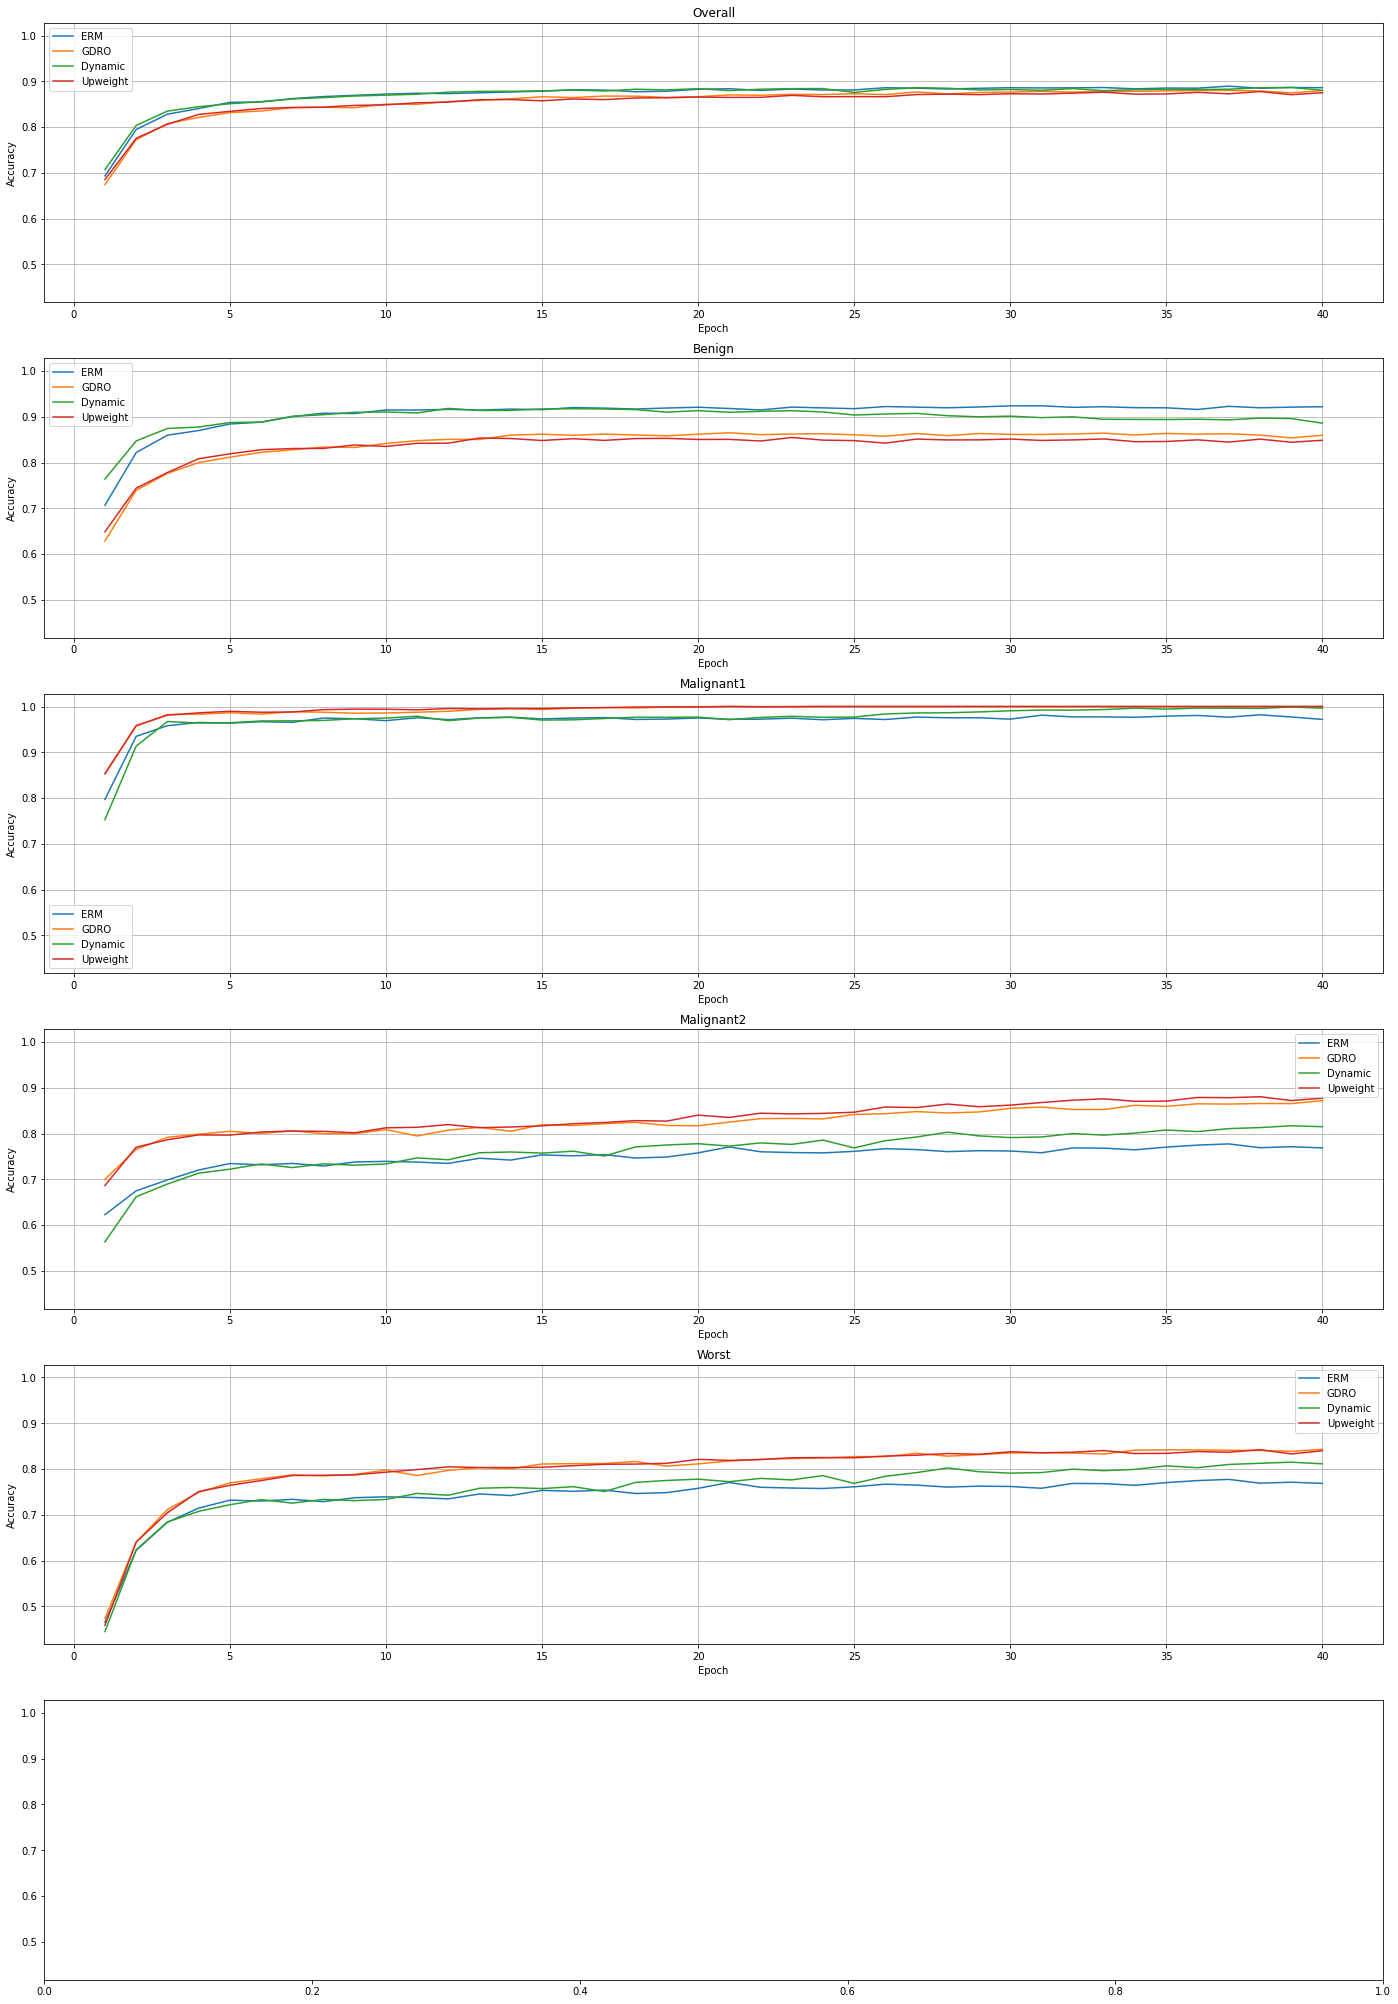

In [38]:
import matplotlib.pyplot as plt

rolling_window = 1

drop_epochs = list(range(40, 100))

rolling_data = trial_means.unstack(level=1).rolling(rolling_window).mean().stack().drop(drop_epochs, level=0, axis=0, inplace=False)
# reindex epochs from 1
rolling_data.index = pd.MultiIndex.from_tuples(zip(rolling_data.index.get_level_values(0) + 1, rolling_data.index.get_level_values(1)), names=["epoch", "subtype"])

plots = [*subtypes, "Worst"]
# plots = ["Overall", "Worst"]

hide = []

w = 1

f, a = plt.subplots((len(plots) + 1) // w, w, sharey=True)

#if len(plots) > w:
  #a = [ax for a0 in a for ax in a0]

# plot subtypes sensitivity

#legend=None,xlim=[55, 60],ylim=[0.85,0.88],

for i in range(len(plots)):
    rolling_data.drop(columns=hide).xs(plots[i], level=1).plot(xlabel="Epoch",ylabel="Accuracy",kind='line',title=plots[i],ax=a[i],figsize=(24, 6 * ((len(plots) + 1) // w)),grid=True)

AttributeError: 'tuple' object has no attribute 'numpy'

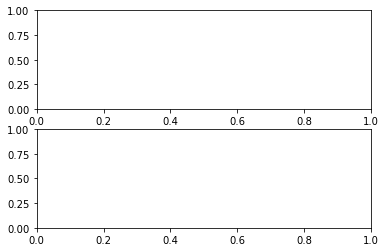

In [ ]:
# ROC curve

from sklearn import metrics

f, a = plt.subplots(len(roc_data), 1)

for i in range(len(roc_data)):
    algorithm = list(roc_data.keys())[i]
    y_true = roc_data[algorithm][1].numpy()
    y_score = roc_data[algorithm][0].numpy()

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(auc)
    a[i].plot(fpr, tpr, 'b')
    a[i].set_title(algorithm)

Overall
ERM: 0.8796744791666666
GDRO: 0.8780338541666667
No significant difference with p = 0.33

Benign
ERM: 0.8872537084652428
GDRO: 0.8789717009363407
ERM greater with p = 0.00

Malignant1
ERM: 0.7750641813979885
GDRO: 0.7995500169821625
GDRO greater with p = 0.00

Malignant2
ERM: 0.9200355649827967
GDRO: 0.9192837708118256
No significant difference with p = 0.78



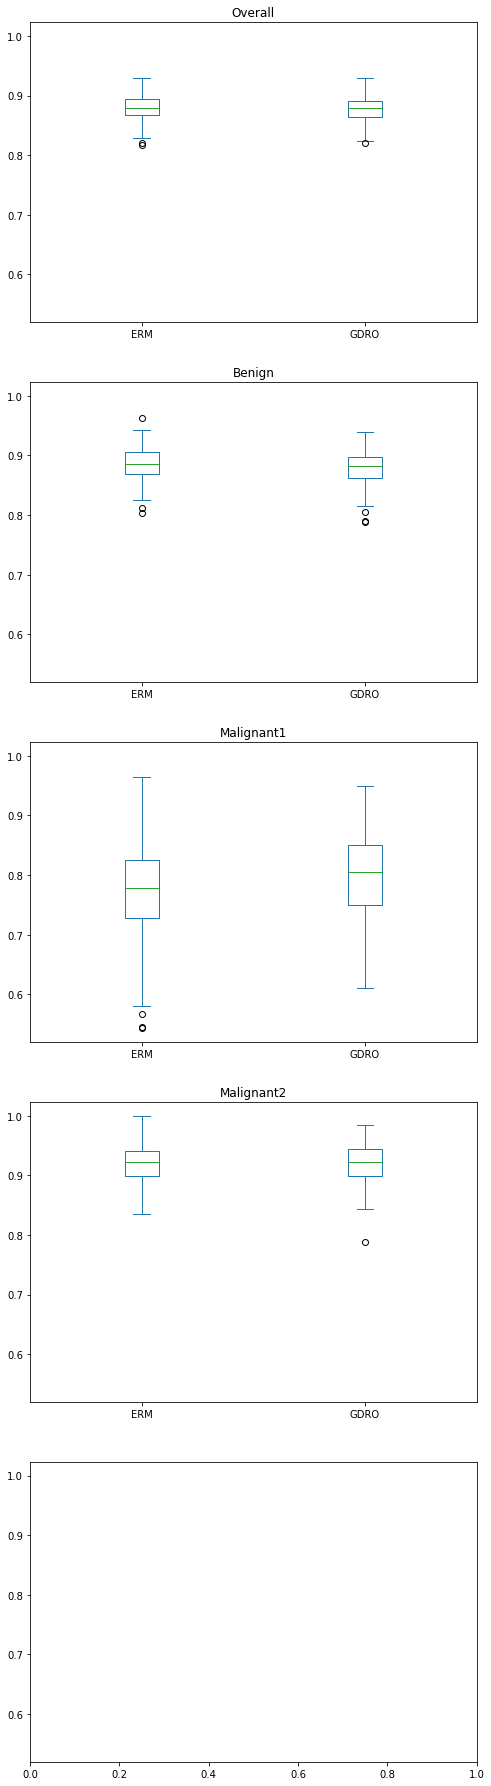

In [ ]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind
from IPython.display import display
import seaborn as sns

significance_threshold = 0.05

ttest_dataframes = {}

f, a = plt.subplots(len(subtypes) + 1,1, sharey=True, figsize=(8,32))

for s in range(len(subtypes)):
#     print(subtype)
#     print()
    subtype_data = results_df.xs(subtypes[s], level=2).xs(epochs - 1, level=1)
    subtype_data.plot(title=subtypes[s], kind='box', ax=a[s])
    
    # worst group data
    # results_df.stack().unstack(level=2).min(axis=1).unstack().xs(epochs - 1, level=1).plot(title='worst', kind='box', ax=a[-1])

    
    erm_data = subtype_data["ERM"].values

    print(subtypes[s])
    for algorithm in results_df.columns:
        if algorithm != "ERM":
            algorithm_data = subtype_data[algorithm].values
            stat, p = ttest_ind(algorithm_data, erm_data)

            print(f'ERM: {erm_data.mean()}')
            print(f'{algorithm}: {algorithm_data.mean()}')
            if p < significance_threshold:
                print(f'{algorithm if stat > 0 else "ERM"} greater with p = {p:.2f}')
            else:
                print(f'No significant difference with p = {p:.2f}')
            print()

In [ ]:
results_df.xs(subtype, level=2).xs(epochs - 1, level=1)

,ERM,GDRO,Dynamic,Upweight
trial,,,,
0,0.859375,0.898438,0.890625,0.855469
1,0.867188,0.843750,0.878906,0.847656
2,0.851562,0.867188,0.878906,0.855469
3,0.851562,0.851562,0.886719,0.914062
4,0.882812,0.832031,0.902344,0.882812
5,0.882812,0.832031,0.890625,0.847656
6,0.859375,0.894531,0.902344,0.859375
7,0.894531,0.777344,0.863281,0.921875
8,0.882812,0.832031,0.875000,0.871094


In [ ]:
# save results
results_df.to_csv('test_results/LIDC__fc64_36_36_2__Adam__eta_0_05__gamma_1_0__lr_0_001__weightdecay_0_0001__momentum_0_9.csv')

In [ ]:
loaded_df = pd.read_csv('test_results/results(1).csv')
N = max(loaded_df["trial"]) + 1
epochs = max(loaded_df["epoch"]) + 1
subtypes = list(loaded_df["subtype"].unique())
algorithms = loaded_df.columns

results = loaded_df.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')

NameError: name 'pd' is not defined

# GDRO Demonstration

In [45]:
epochs = 30
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = model_class(*model_args).to(device)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn.t = 0

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train_eval.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

AttributeError: ignored

In [ ]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

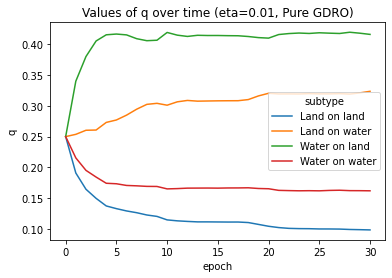

In [ ]:
q_df.plot(xlabel="epoch", ylabel="q", title=f"Values of q over time (eta={hparams['groupdro_eta']}, Pure GDRO)")

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)

,InstanceID,StudyInstanceUID,SeriesInstanceUid,RadiologistID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,...,CNN_27,CNN_28,CNN_29,CNN_30,CNN_31,CNN_32,CNN_33,CNN_34,CNN_35,CNN_36
0,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,...,-5.395743,1.582677,-4.063280,-5.070021,3.163702,5.290330,-2.523472,3.713529,-0.649701,4.314638
1,75,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,4,2,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1....,1,1,6,...,-5.850334,5.002493,-3.661947,-3.624461,3.235335,-3.922062,-2.210064,6.059101,-0.500276,5.508437
2,134,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,...,-4.822973,2.920556,-5.047228,-5.552570,3.489042,0.851557,-2.870659,6.073289,-0.647323,6.486247
3,143,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,...,-7.574823,7.260141,-6.138217,-6.386428,4.904528,-2.540447,-2.647656,8.163655,-0.035022,8.056358
4,118,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,3,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,...,-7.165000,6.356084,-6.882338,-5.712488,5.102713,-2.921033,-2.749318,9.136231,-0.171229,8.867806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,30321,1.3.6.1.4.1.14519.5.2.1.6279.6001.112366982107...,1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727...,2,2686,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0770\1.3.6.1....,5,1,6,...,-4.363398,1.216722,-3.386296,-4.855748,2.966221,5.028000,-2.105534,4.931665,-0.734520,4.226719
2682,32539,1.3.6.1.4.1.14519.5.2.1.6279.6001.213747445868...,1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...,2,2687,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0815\1.3.6.1....,4,1,6,...,-5.684091,4.747817,-3.803551,-3.821561,3.346258,-2.903088,-2.005761,5.487472,-0.402588,5.502116
2683,35559,1.3.6.1.4.1.14519.5.2.1.6279.6001.323769537371...,1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046...,4,2688,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0871\1.3.6.1....,4,1,6,...,0.528109,-2.443759,3.613519,5.157967,-0.401557,-2.264581,4.815277,-1.387713,-0.522287,-1.254572
2684,37212,1.3.6.1.4.1.14519.5.2.1.6279.6001.232772963487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785...,4,2689,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0916\1.3.6.1....,1,1,6,...,1.710828,-2.952641,4.176023,7.256946,-0.778750,-2.928508,6.510663,-2.376418,-0.569608,-1.775246
